# 💪Procesamiento de Señales EMG con Filtros Digitales  

Este notebook presenta el flujo de trabajo para el procesamiento de señales EMG obtenidas del bíceps braquial en distintas condiciones (reposo, contracción lenta y contramovimiento).  
Se aplican filtros digitales de distintos tipos (Butterworth, Chebyshev, y FIR con ventanas Hamming y Blackman) para evaluar su desempeño en la limpieza de la señal y el cálculo del SNR (Signal-to-Noise Ratio).  

## 🛠️ 1. Importación de librerías  

En este caso utilizaremos las siguientes librerías de Python:  

- **pandas (`pd`)**: para cargar y manipular archivos de texto (`.csv` o `.txt`) que contienen las señales EMG y los coeficientes de los filtros.  
- **numpy (`np`)**: para realizar cálculos numéricos y operaciones vectoriales (FFT, potencia, etc.).  
- **matplotlib (`plt`)**: para graficar las señales crudas, filtradas y sus espectros.  
- **scipy.signal (`lfilter`)**: para aplicar los filtros digitales definidos por sus coeficientes.  

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

## 📂 2. Archivos de señales EMG  

Definimos las rutas de los archivos que contienen las señales EMG en formato `.txt`.  
Cada archivo corresponde a una condición experimental:  

- **Reposo2Biceps** → actividad basal del músculo.  
- **Lento2Biceps** → contracción lenta del bíceps braquial.  
- **ContraBiceps2** → contramovimiento o contracción contra resistencia.  

In [32]:
# === 1. Archivos de señales EMG ===
archivos = {
    "Reposo2Biceps": r"C:\SeñalesLab3\Reposo2Biceps.txt",
    "Lento2Biceps": r"C:\SeñalesLab3\Lento2Biceps.txt",
    "ContraBiceps2": r"C:\SeñalesLab3\ContraBiceps2.txt"
}

## ⚙️ 3. Configuración del sensor  

Se establecen las características del sistema de adquisición de datos:  

- **VCC = 3.3 V**: tensión de referencia del ADC.  
- **Gain = 1009**: ganancia de la etapa de amplificación del sensor EMG.  
- **ADCres = 1023**: resolución del ADC de 10 bits (0–1023).  
- **fs = 1000 Hz**: frecuencia de muestreo de la señal.  

In [33]:
# === 2. Configuración del sensor ===
VCC = 3.3
Gain = 1009
ADCres = 1023
fs = 1000

## 📥 4. Función para cargar señal EMG cruda  

Se define una función que:  
1. Carga los datos desde el archivo `.txt`.  
2. Convierte los valores digitales (ADC) en voltaje.  
3. Ajusta la escala a milivoltios (mV).  
4. Elimina el componente DC restando la media de la señal.  

In [34]:
# === 3. Función para cargar señal EMG cruda ===
def cargar_emg(ruta):
    df = pd.read_csv(ruta, sep="\t", comment="#",
                     names=["nSeq", "I1", "I2", "O1", "O2", "A1"])
    ADC = df["O2"].values
    EMG_V = ((ADC / ADCres) - 0.5) * VCC / Gain
    EMG_mV = EMG_V * 1000
    return EMG_mV - EMG_mV.mean()

## 📊 5. Función para cargar coeficientes de filtros  

Se crea una función que carga desde un archivo `.csv` los coeficientes **b** y **a** de los filtros.  

- En los **filtros IIR** (Butterworth, Chebyshev) se usan coeficientes `b` (numerador) y `a` (denominador).  
- En los **filtros FIR** (Hamming, Blackman) el denominador se fija en `a = 1.0`, ya que no tienen retroalimentación.  

In [35]:
# === 4. Función para cargar coeficientes de filtro ===
def cargar_coef(ruta, fir=False):
    coef = pd.read_csv(ruta)
    b = coef["b"].dropna().values
    if fir:
        a = [1.0]
    else:
        a = coef["a"].dropna().values
    return b, a


## 📐 6. Función para calcular el SNR (Signal-to-Noise Ratio)  

El **SNR** se calcula a partir de la **Transformada Rápida de Fourier (FFT)**:  

- **Señal útil**: potencia en el rango de 20–450 Hz (banda típica de señales EMG).  
- **Ruido**: potencia fuera de esa banda.  
- **SNR**: relación señal/ruido en decibelios (dB).  

In [36]:
# === 5. Función para calcular SNR usando FFT en banda de interés ===
def calcular_snr_fft(señal, fs, f_low=20, f_high=450):
    N = len(señal)
    F = np.fft.fft(señal)
    freqs = np.fft.fftfreq(N, 1/fs)

    # Potencia de señal en banda 20-450 Hz
    idx_signal = (np.abs(freqs) >= f_low) & (np.abs(freqs) <= f_high)
    P_signal = np.sum(np.abs(F[idx_signal])**2)

    # Potencia de ruido fuera de la banda
    P_noise = np.sum(np.abs(F[~idx_signal])**2)

    snr = 10 * np.log10(P_signal / P_noise)
    return snr


## 🎚️ 7. Rutas de coeficientes de filtros  

Se definen las rutas de los archivos `.csv` que contienen los coeficientes para cada tipo de filtro:  

- **Butterworth (IIR)**  
- **Chebyshev Tipo I (IIR)**  
- **FIR Hamming**  
- **FIR Blackman**  

In [37]:
# === 6. Rutas de coeficientes ===
rutas_filtros = {
    "Butterworth": {
        "bp": r"C:\Users\DELL\Documents\lab2\Laboratorio 6 - Filtros Digitales\PasabandaButterworth.csv",
        "notch": r"C:\Users\DELL\Documents\lab2\Laboratorio 6 - Filtros Digitales\NotchButterworth.csv",
        "fir": False
    },
    "Chebyshev I": {
        "bp": r"C:\Users\DELL\Documents\lab2\Laboratorio 6 - Filtros Digitales\PasabandaChevyshev1.csv",
        "notch": r"C:\Users\DELL\Documents\lab2\Laboratorio 6 - Filtros Digitales\NotchChevyshev1.csv",
        "fir": False
    },
    "Hamming": {
        "bp": r"C:\Users\DELL\Documents\lab2\Laboratorio 6 - Filtros Digitales\PasabandaHamming.csv",
        "notch": r"C:\Users\DELL\Documents\lab2\Laboratorio 6 - Filtros Digitales\NotchHamming.csv",
        "fir": True
    },
    "Blackman": {
        "bp": r"C:\Users\DELL\Documents\lab2\Laboratorio 6 - Filtros Digitales\PasabandaBlackman.csv",
        "notch": r"C:\Users\DELL\Documents\lab2\Laboratorio 6 - Filtros Digitales\NotchBlackman.csv",
        "fir": True
    }
}


## 📈 8. Procesamiento de señales y cálculo de SNR  

En este bloque se realiza el procesamiento completo:  

1. **Carga de la señal cruda**.  
2. **Aplicación del filtro pasabanda**.  
3. **Aplicación del filtro notch** (para eliminar ruido de red 50/60 Hz).  
4. **Cálculo del SNR en banda 20–450 Hz**.  
5. **Visualización**:  
   - Señal cruda.  
   - Señal filtrada.  
   - Espectro en frecuencia comparando cruda vs filtrada. 

SNR de Reposo2Biceps con Butterworth: 29.53 dB


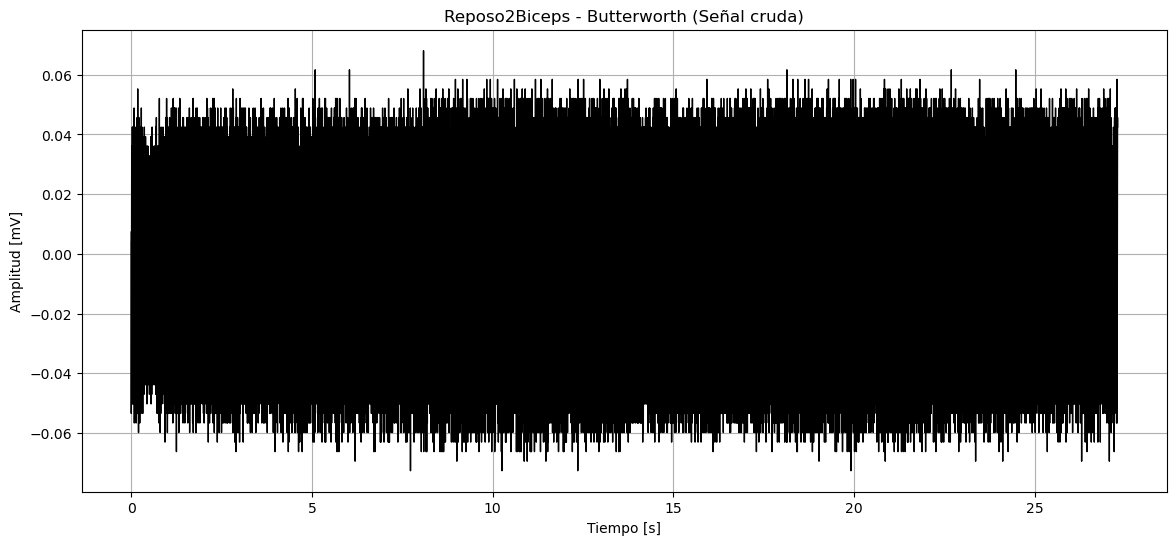

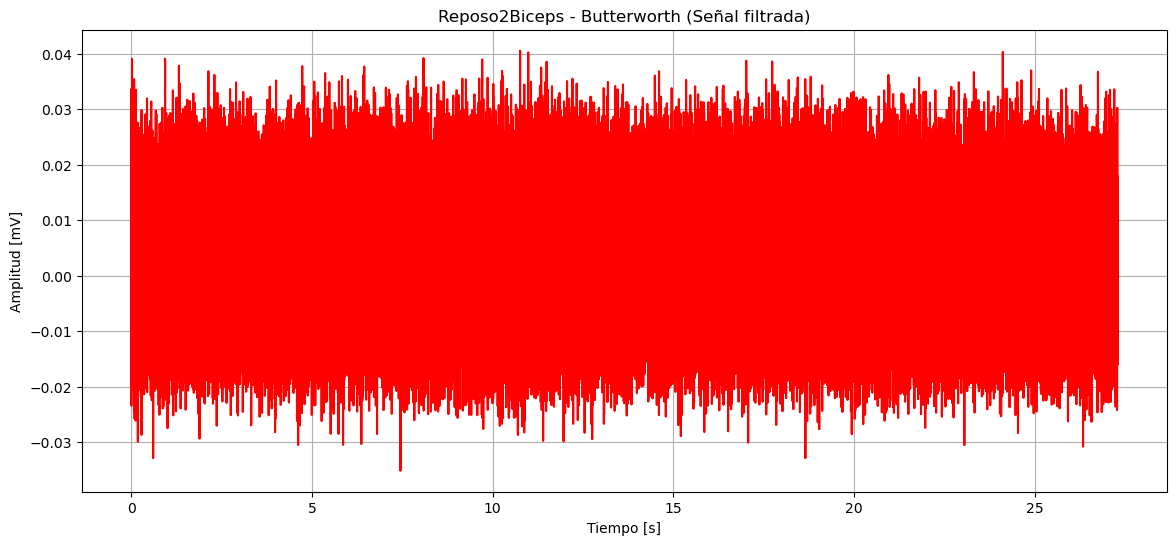

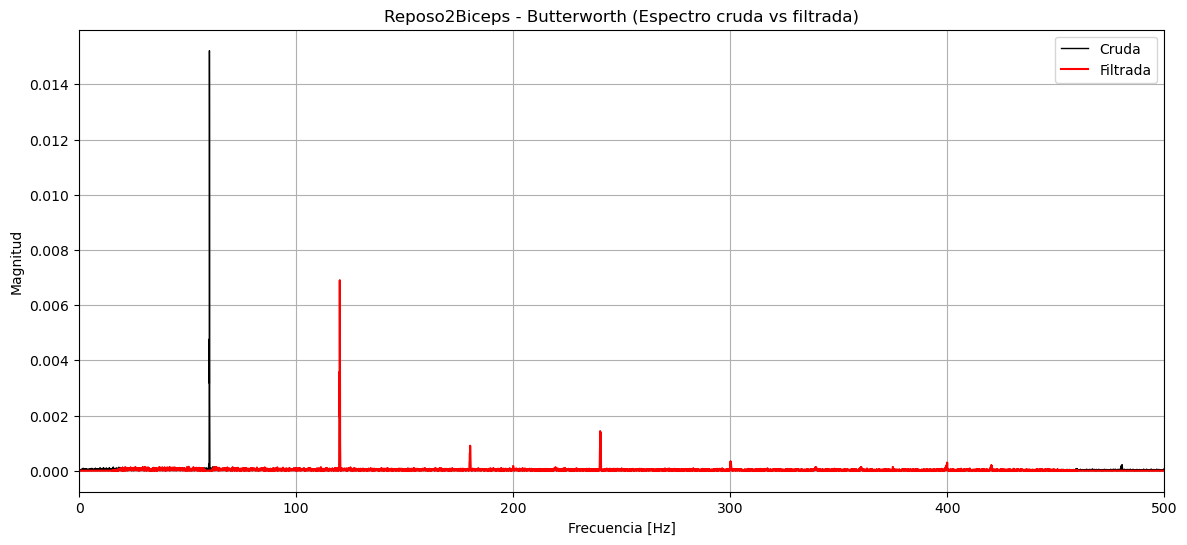

SNR de Reposo2Biceps con Chebyshev I: 33.93 dB


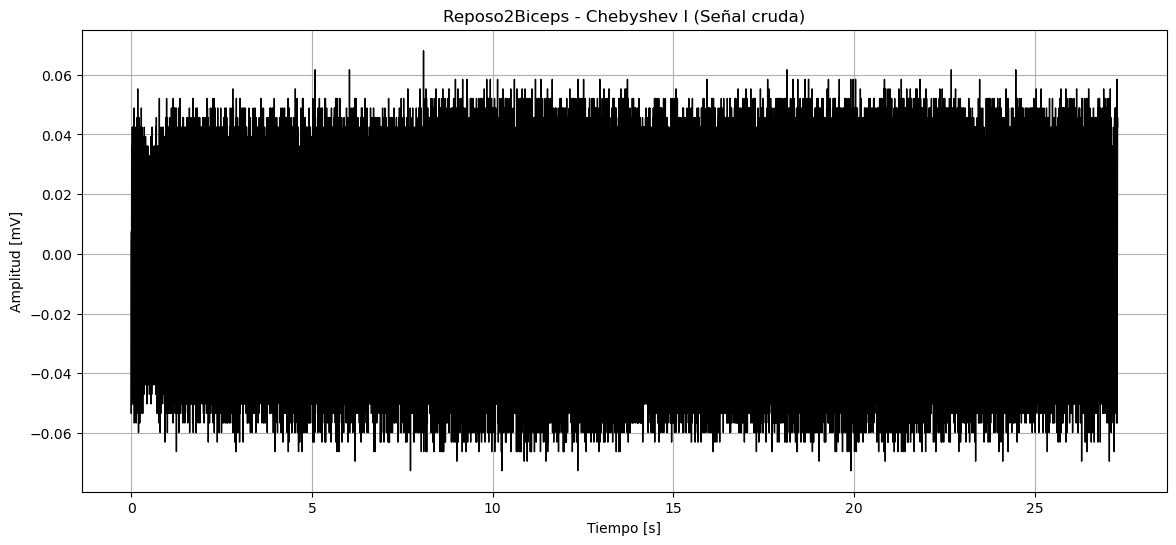

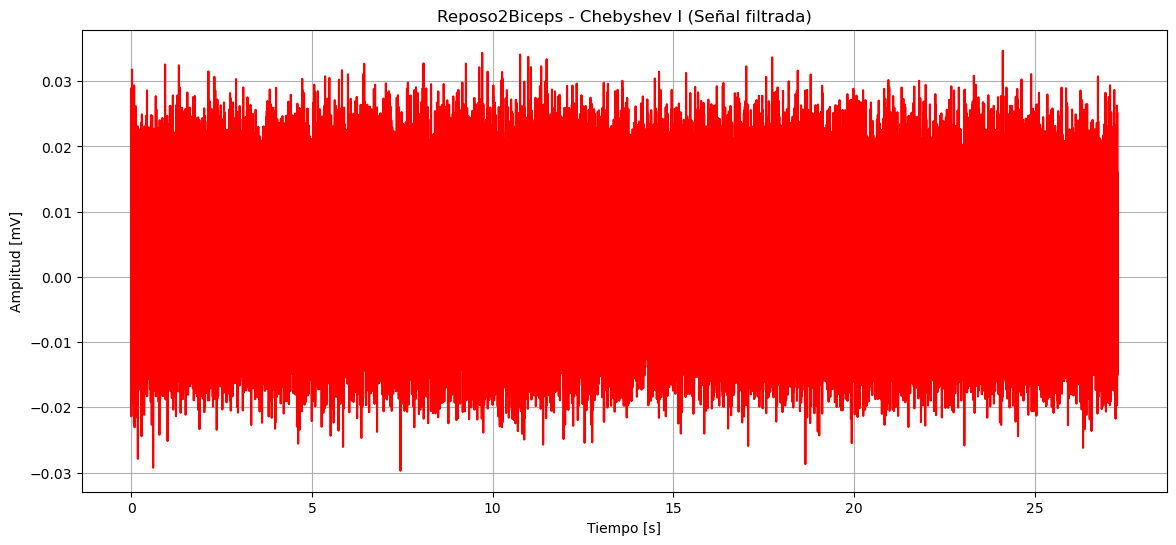

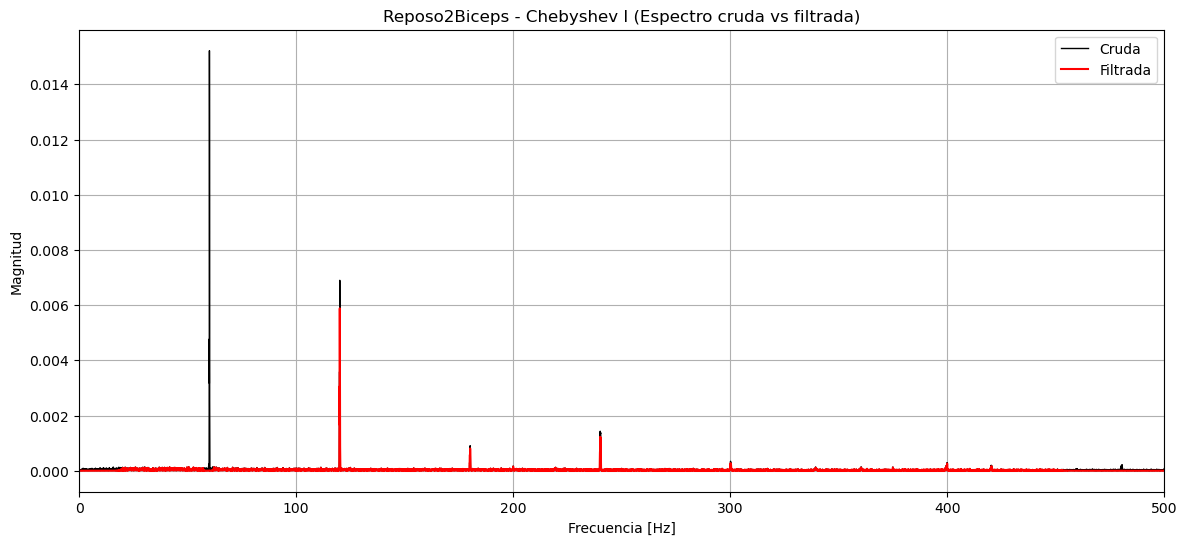

SNR de Reposo2Biceps con Hamming: 24.81 dB


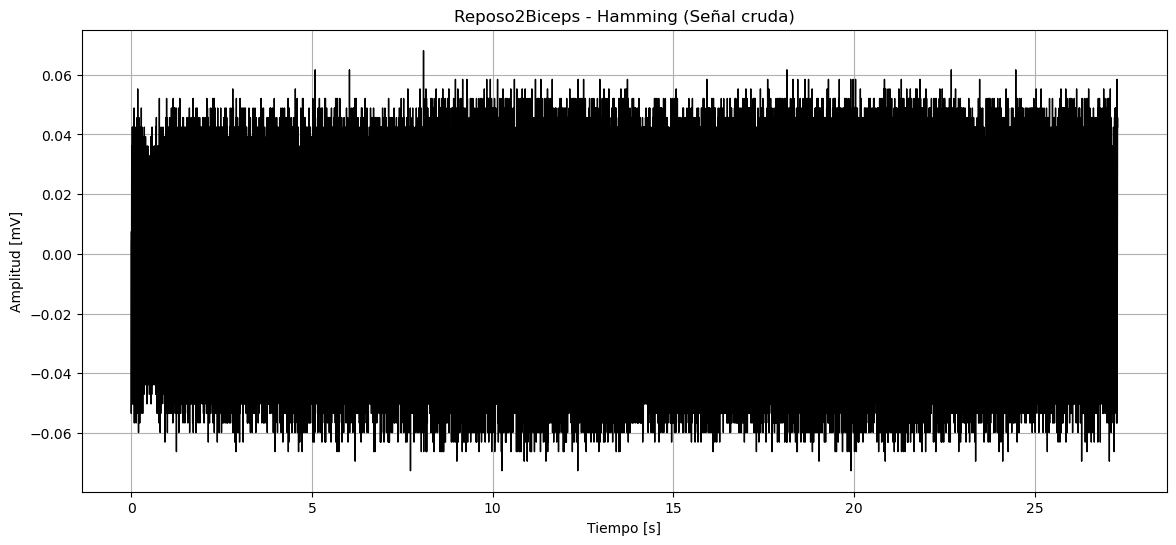

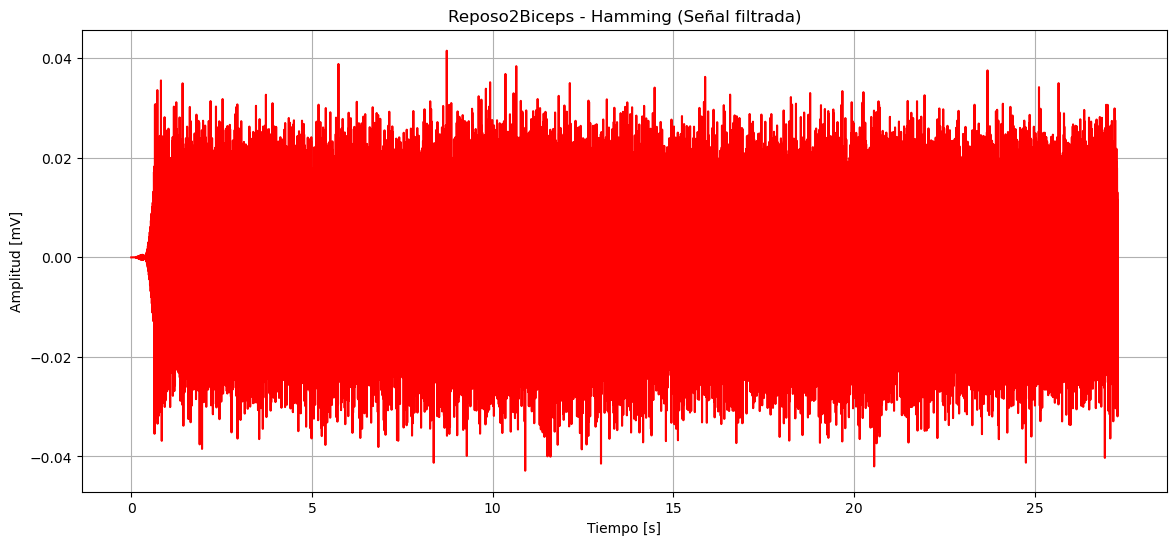

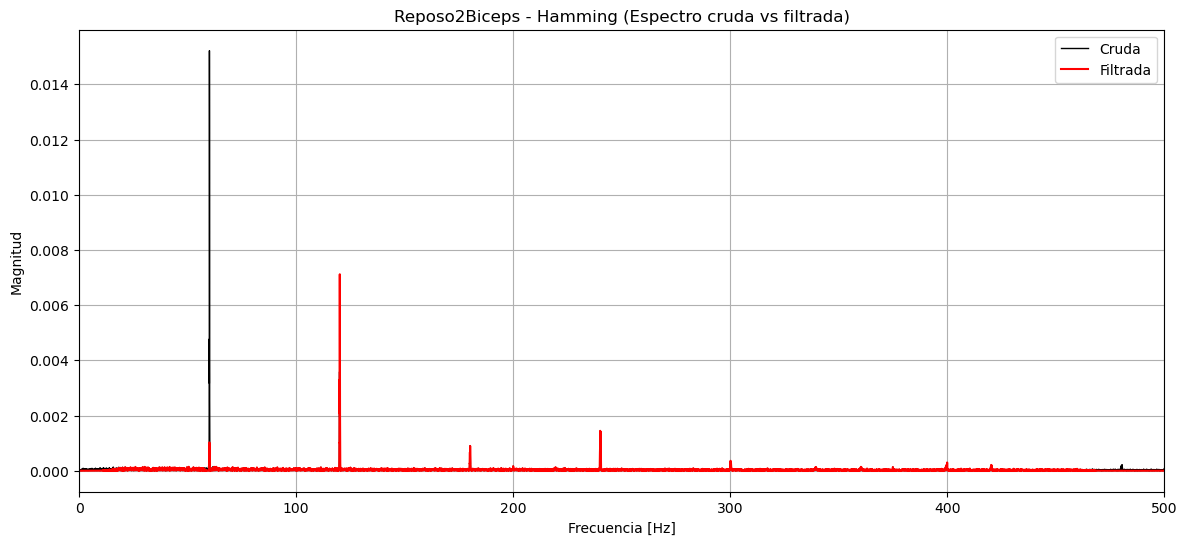

SNR de Reposo2Biceps con Blackman: 25.26 dB


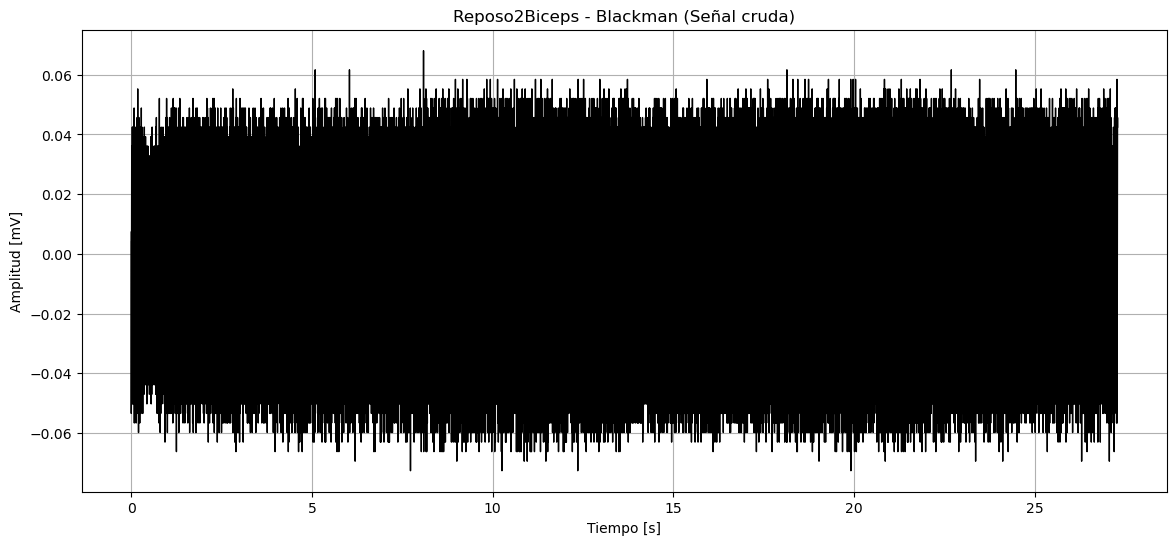

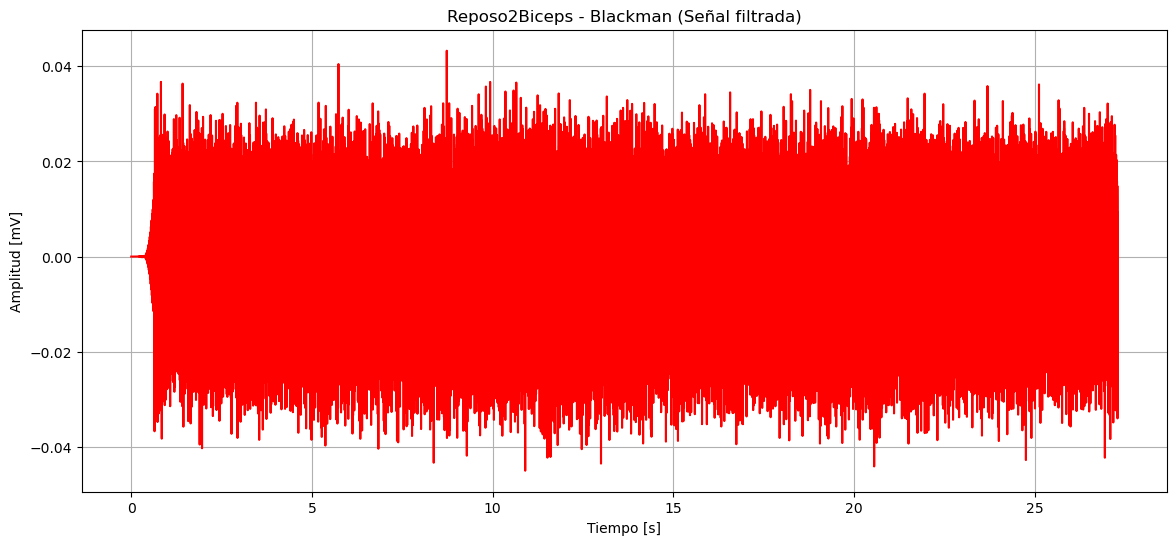

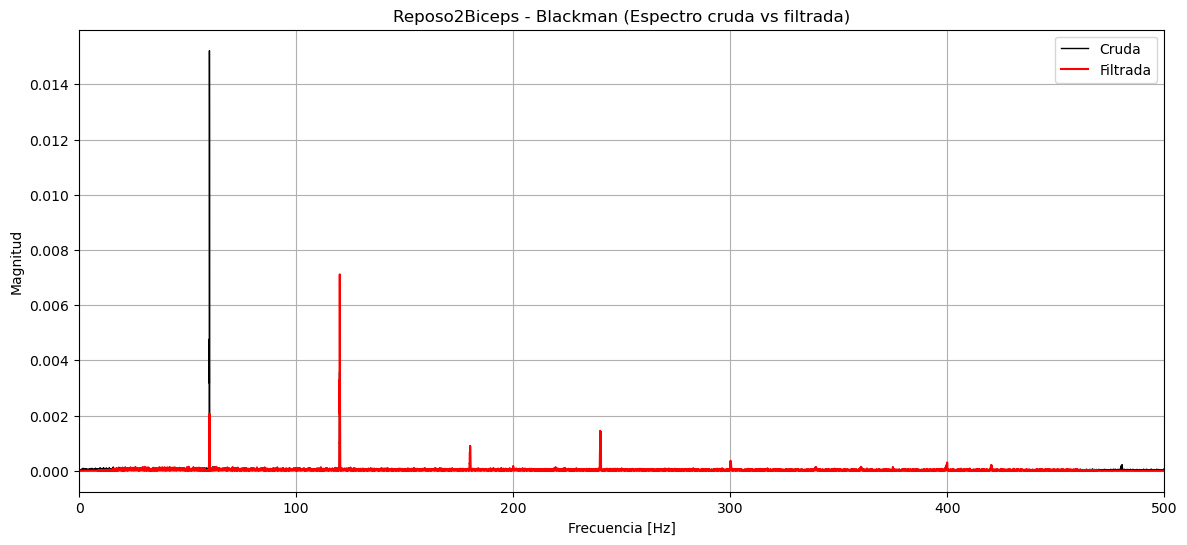

SNR de Lento2Biceps con Butterworth: 24.50 dB


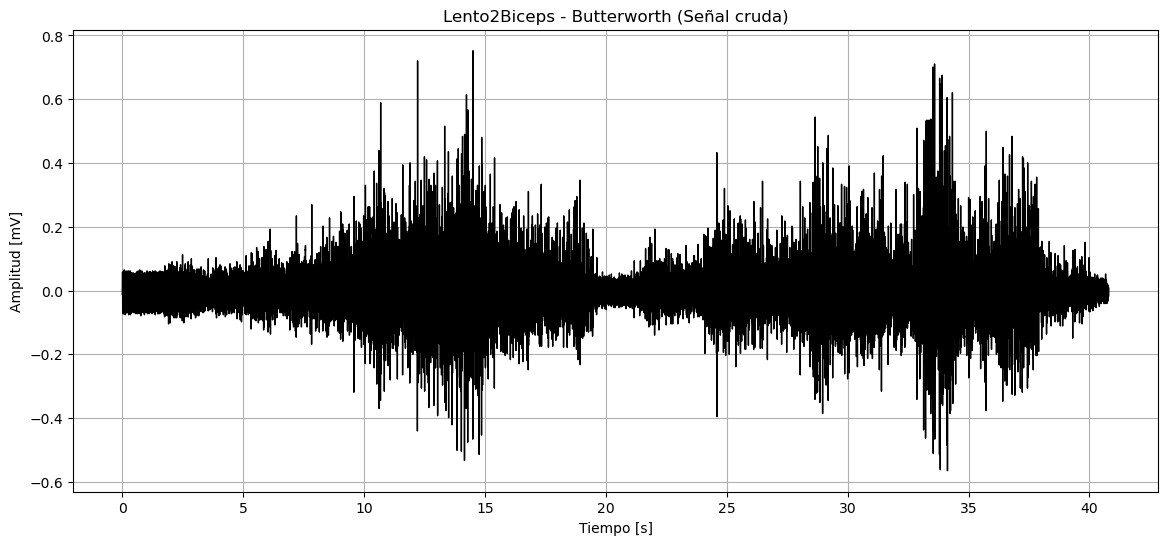

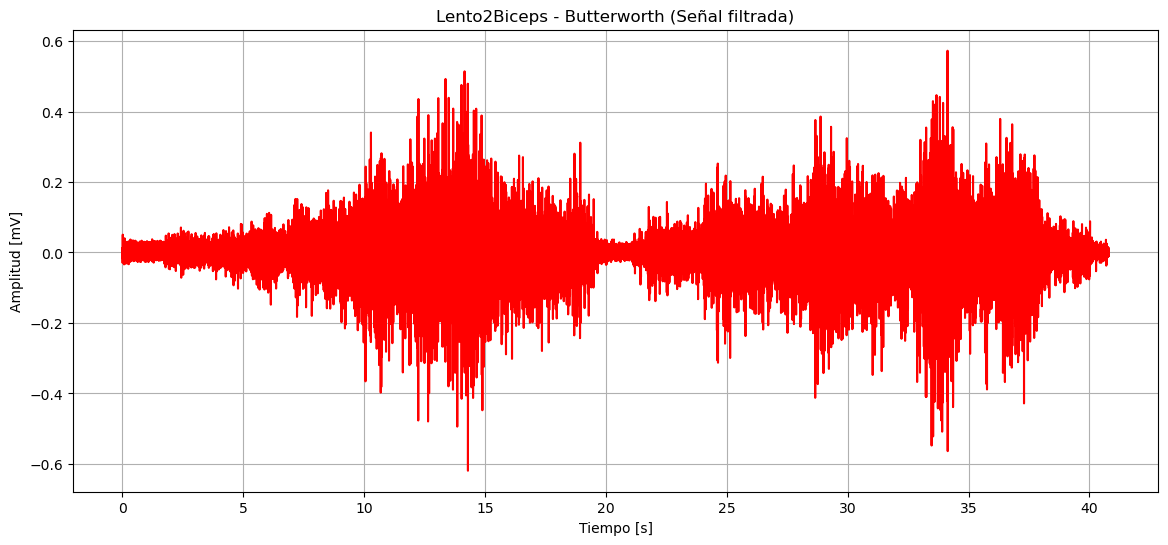

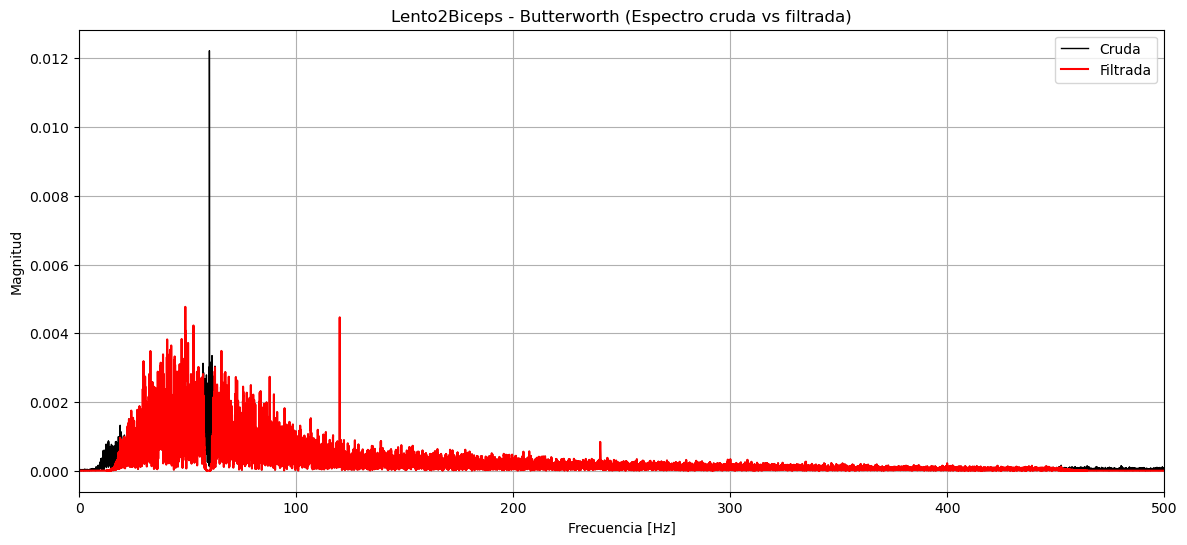

SNR de Lento2Biceps con Chebyshev I: 28.31 dB


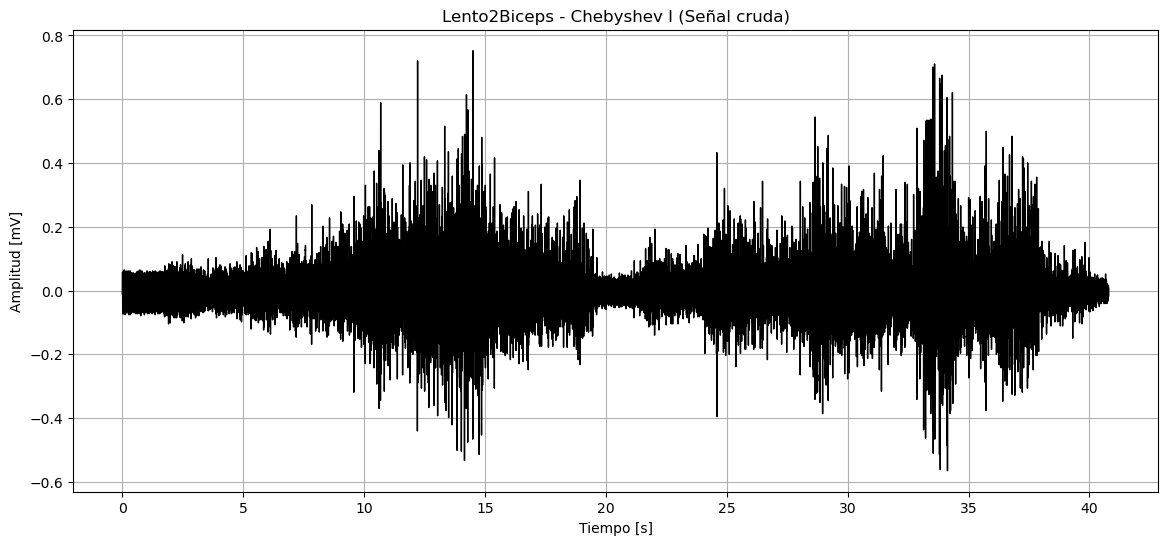

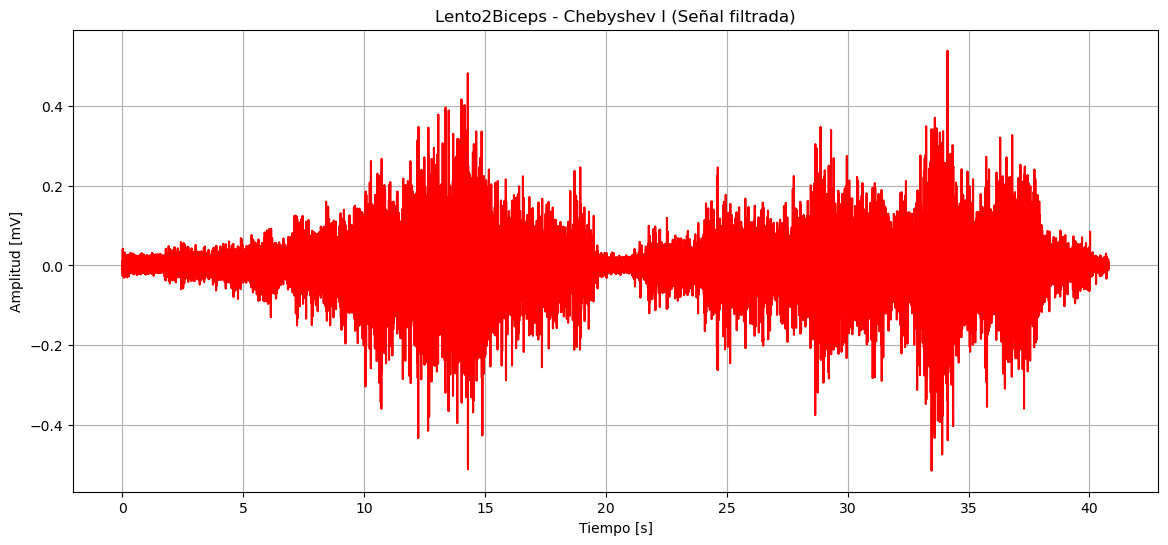

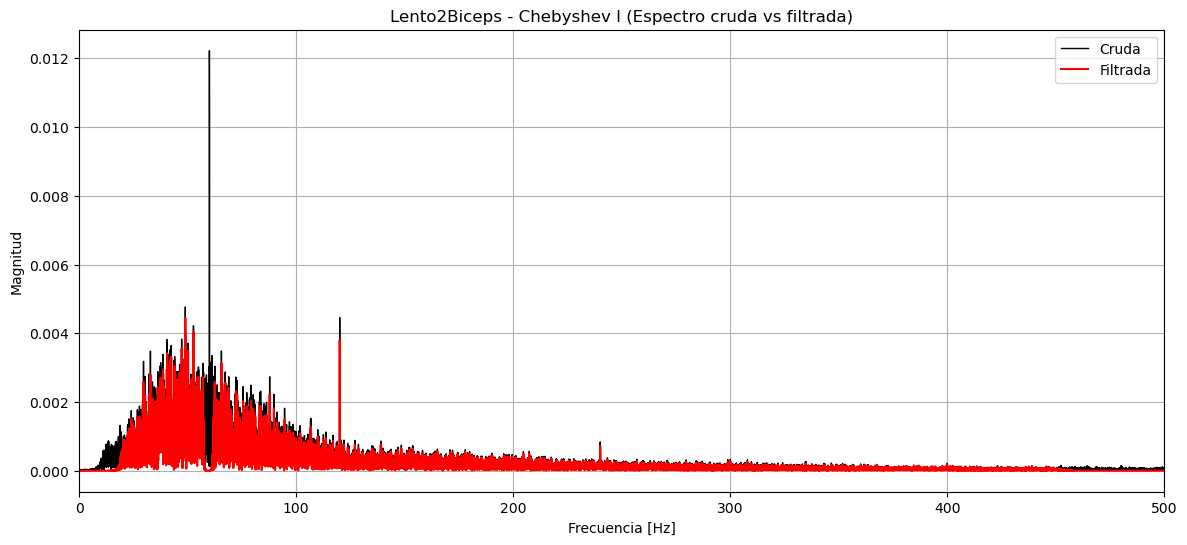

SNR de Lento2Biceps con Hamming: 21.75 dB


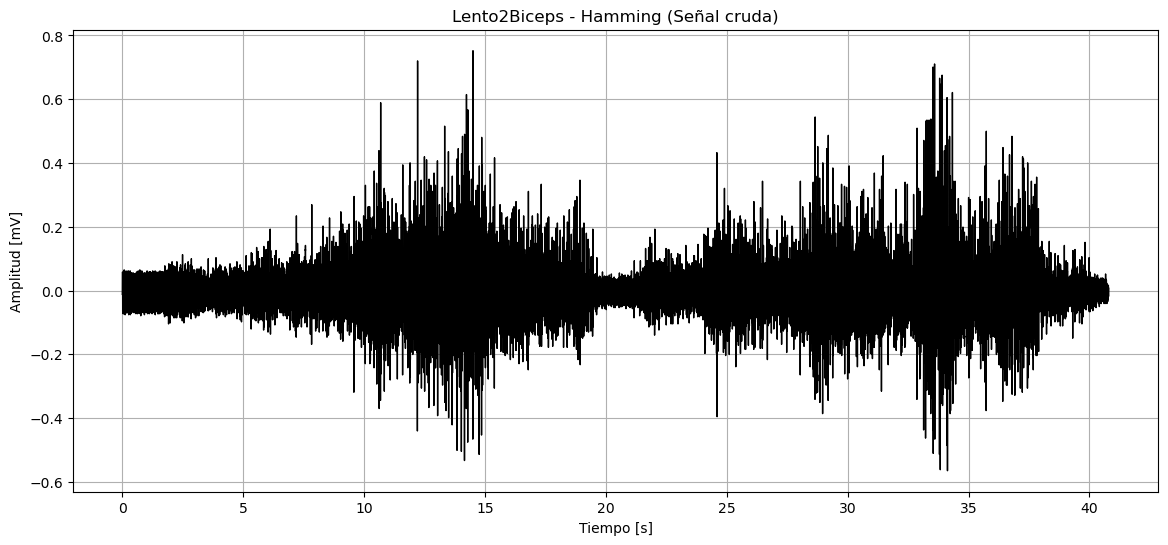

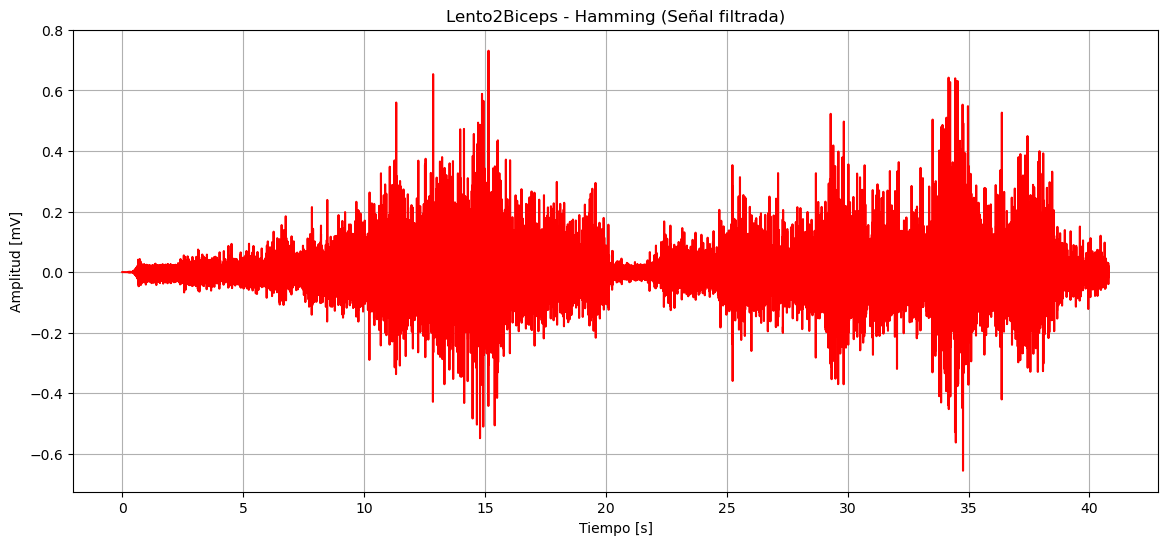

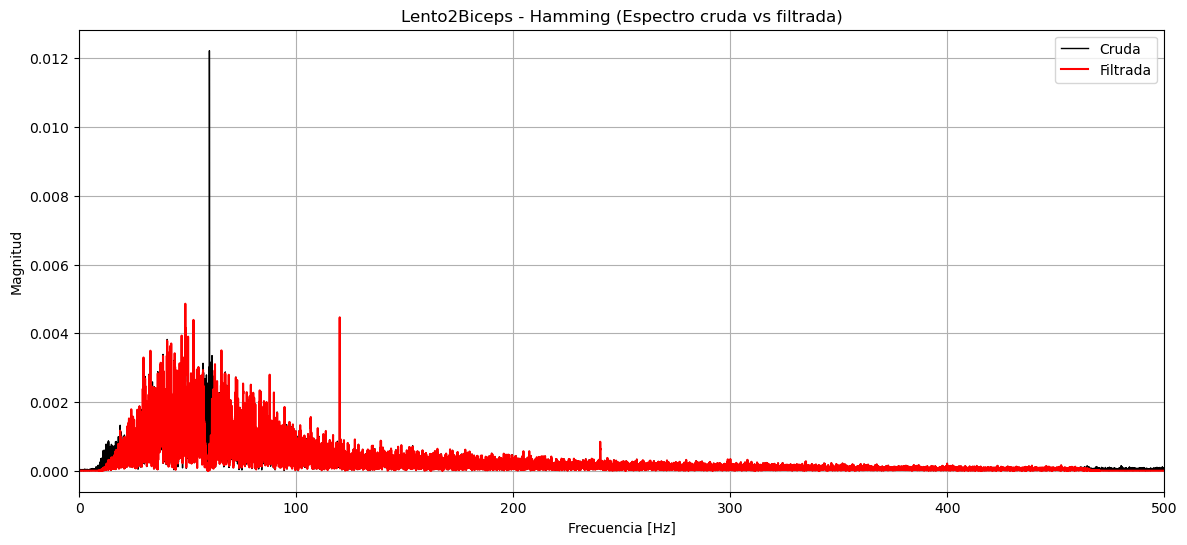

SNR de Lento2Biceps con Blackman: 22.18 dB


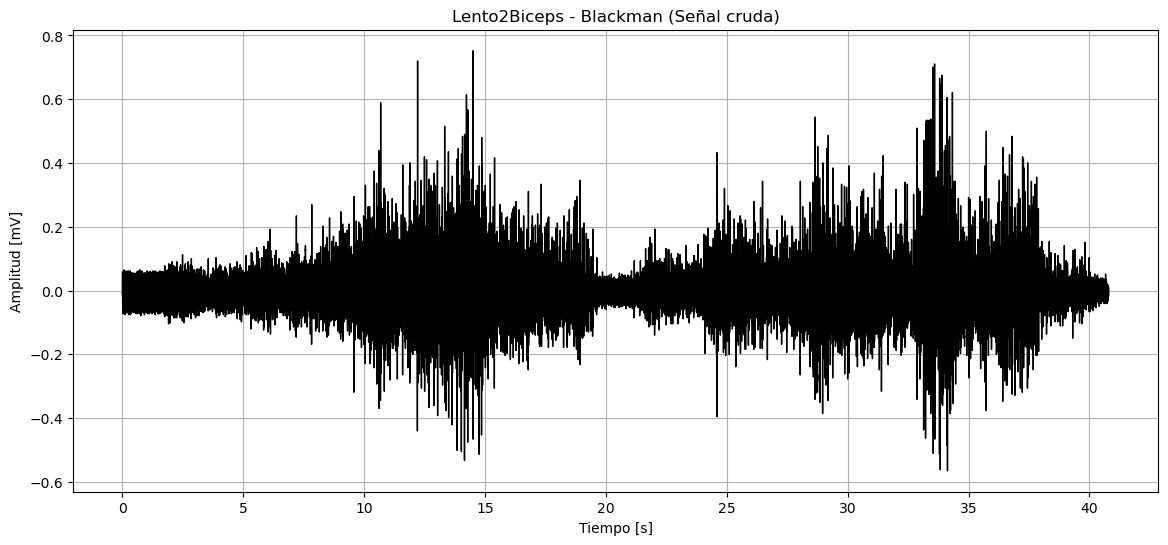

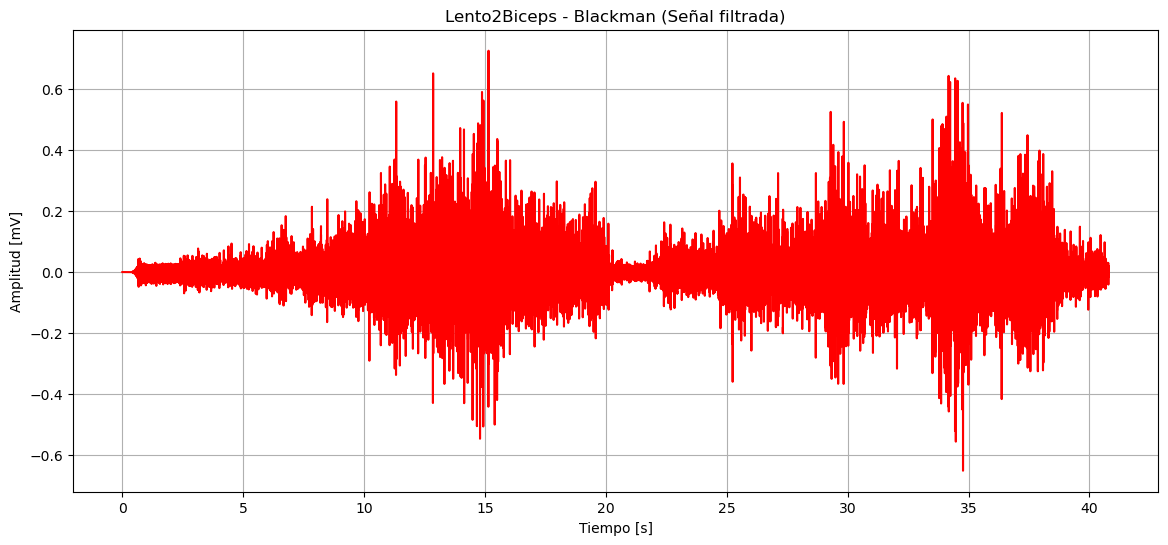

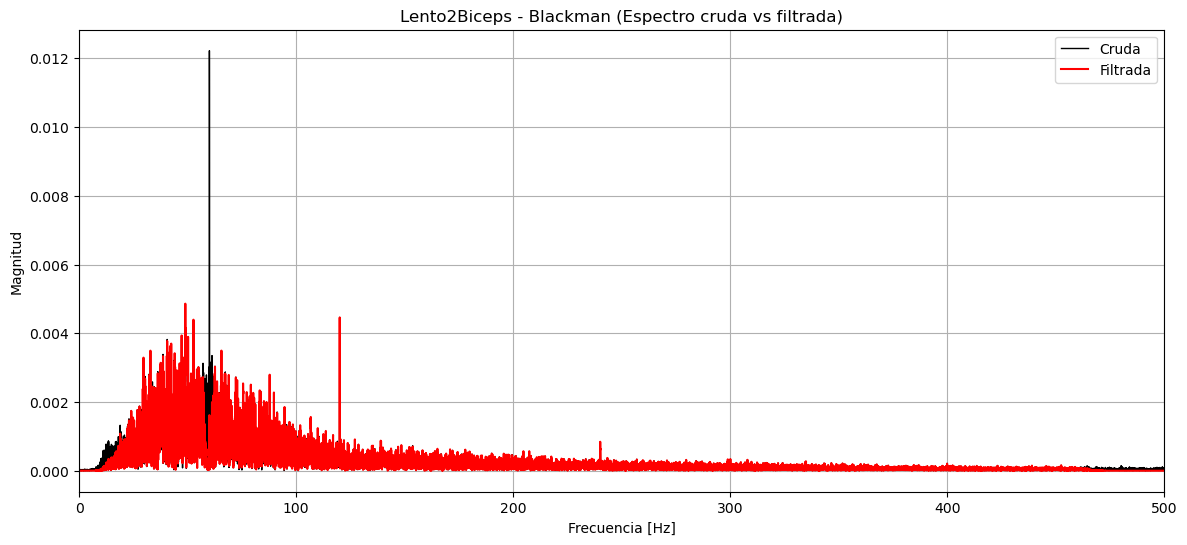

SNR de ContraBiceps2 con Butterworth: 23.37 dB


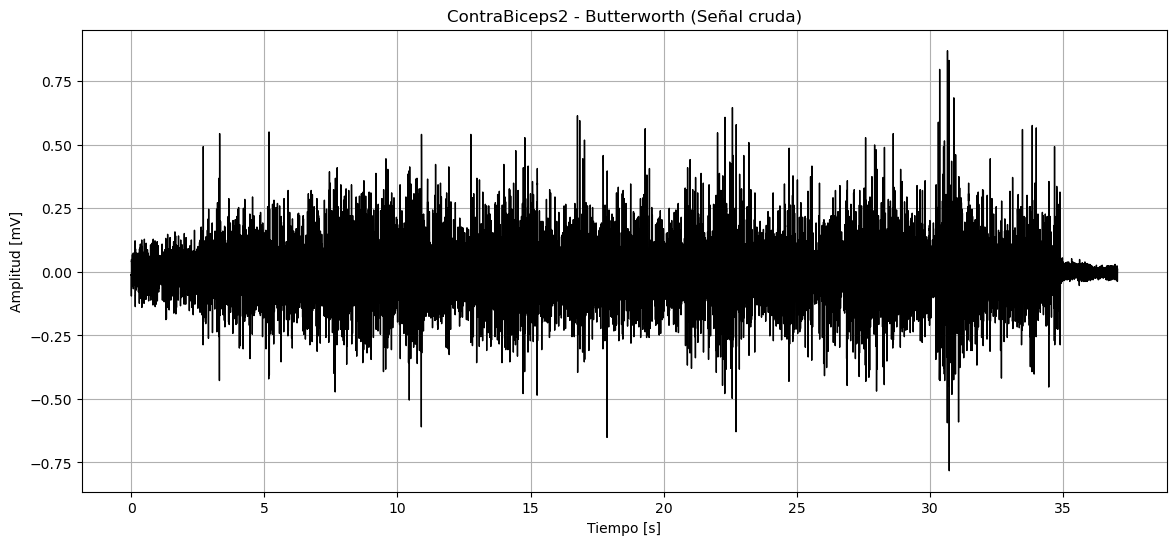

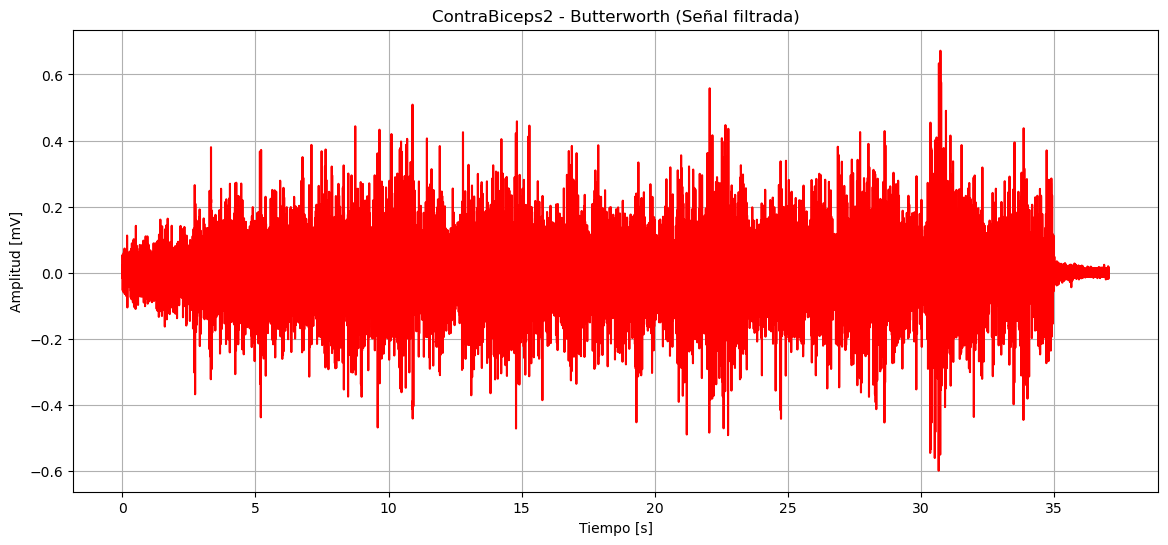

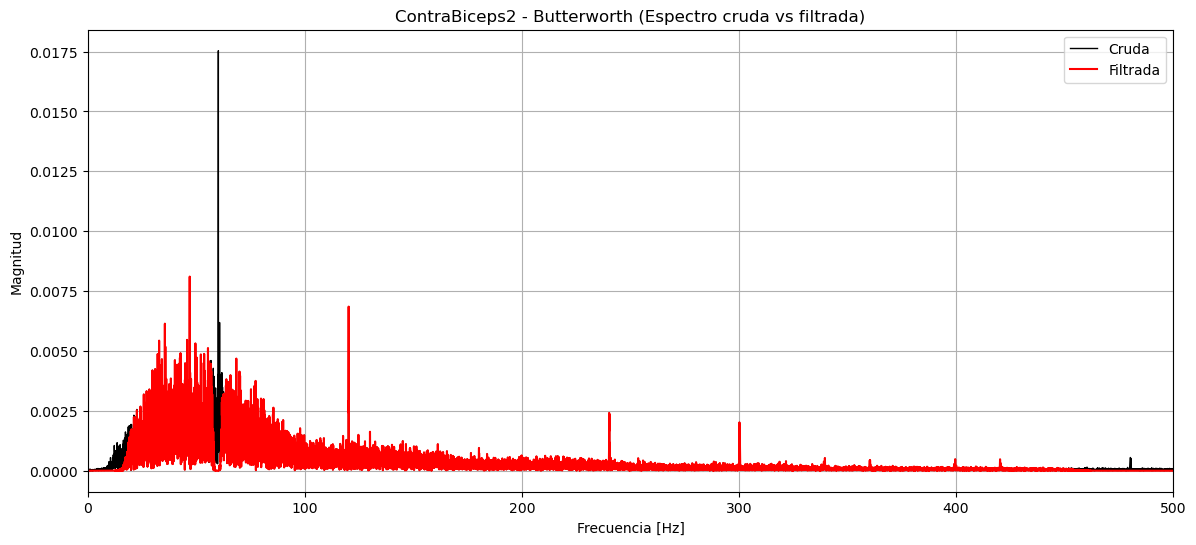

SNR de ContraBiceps2 con Chebyshev I: 27.29 dB


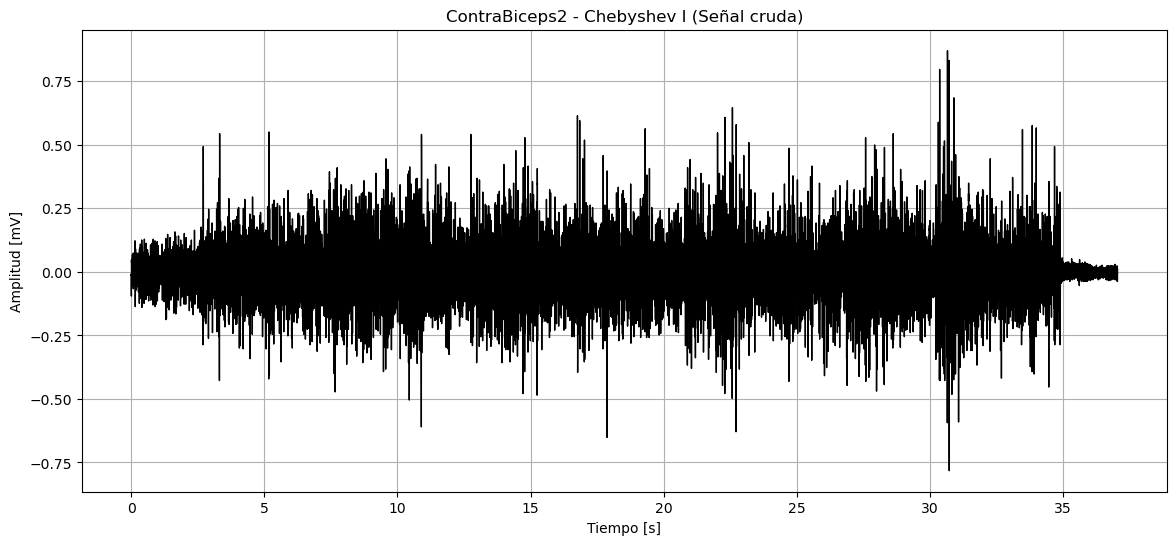

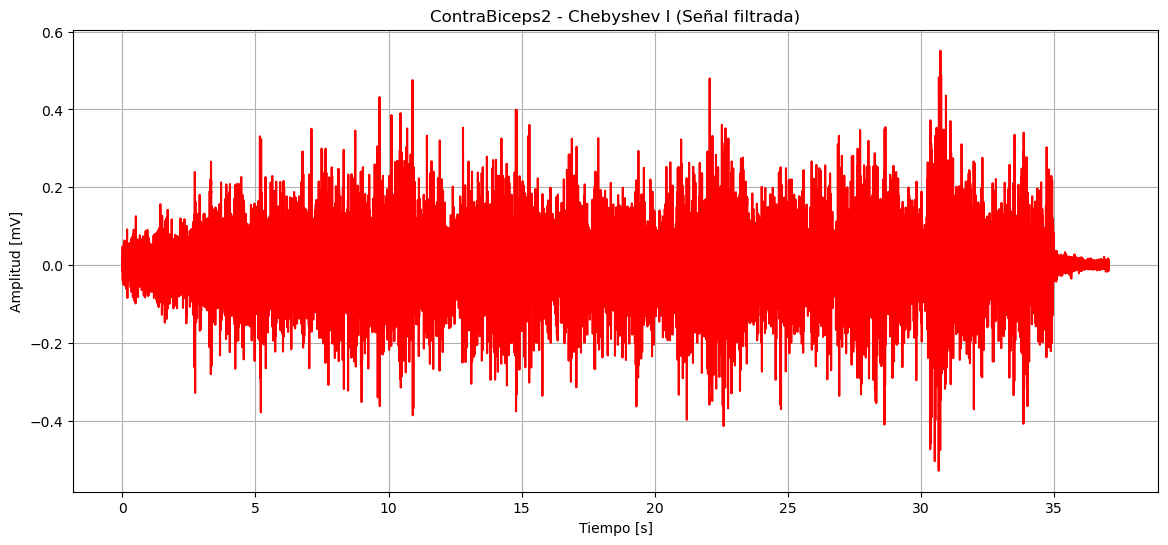

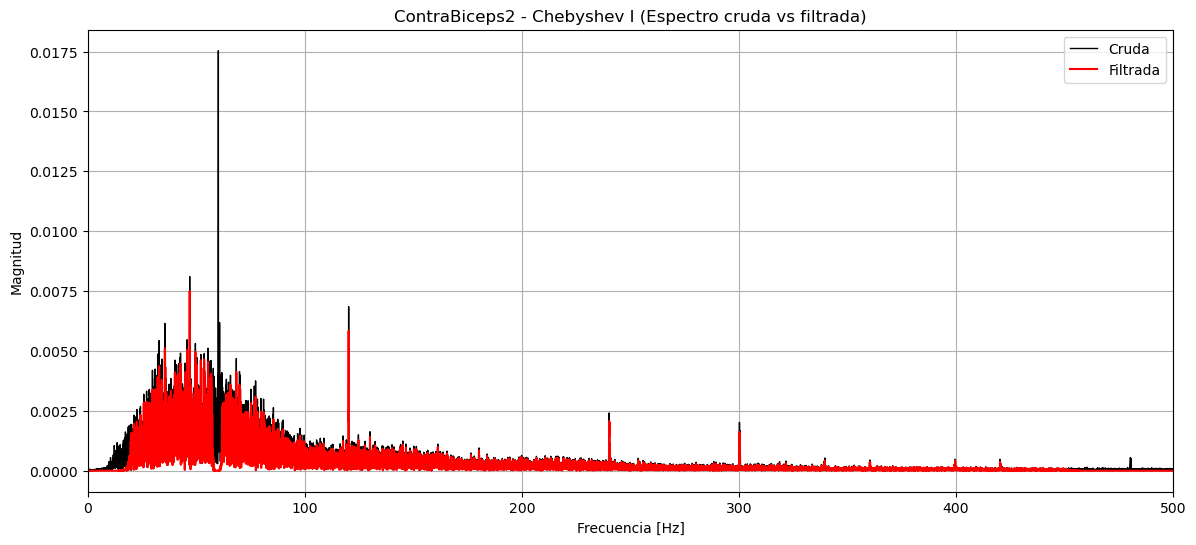

SNR de ContraBiceps2 con Hamming: 20.41 dB


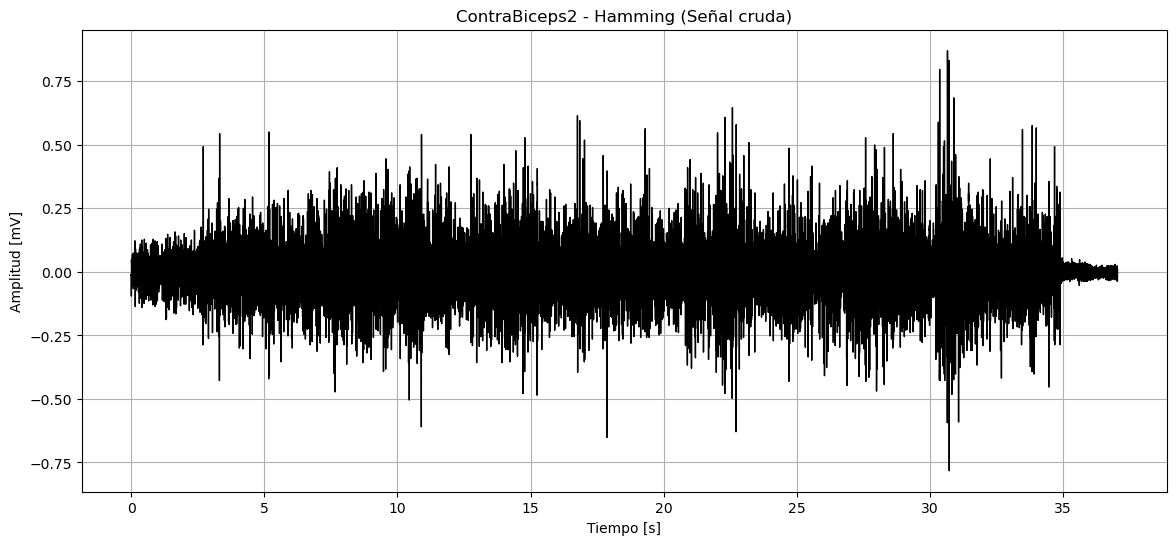

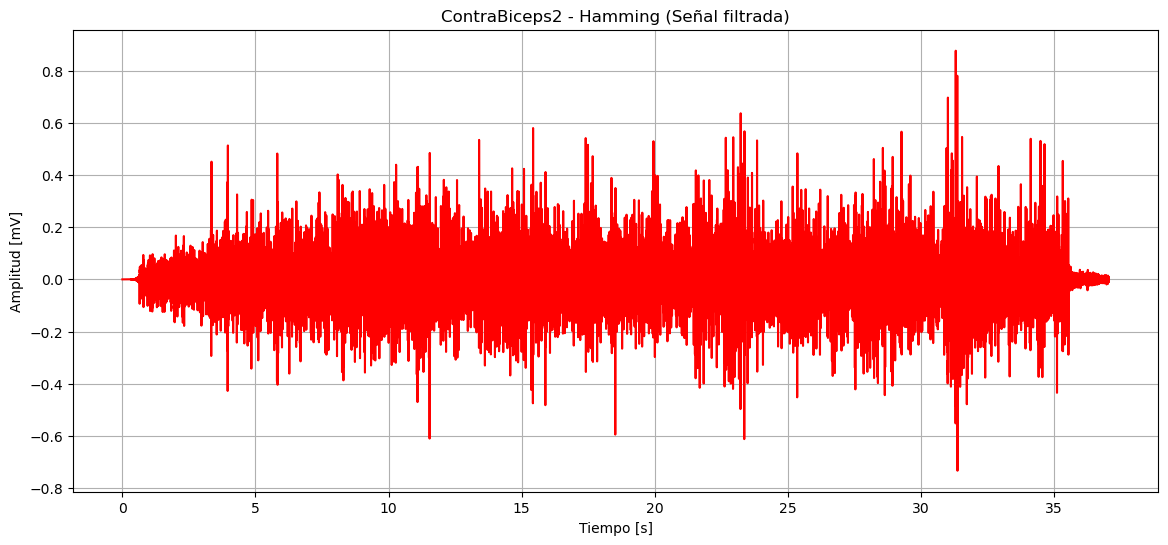

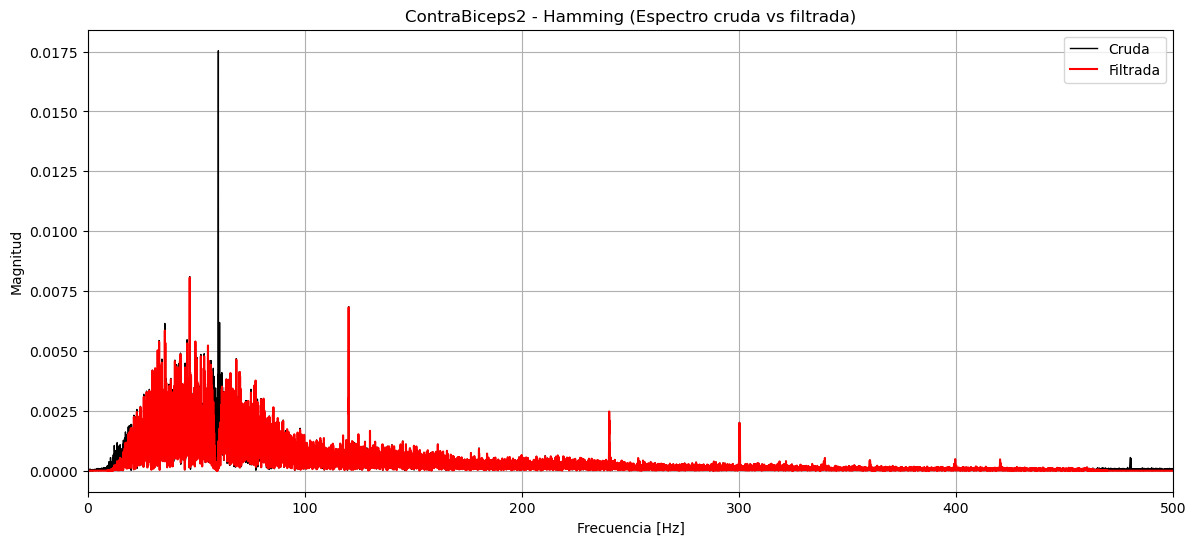

SNR de ContraBiceps2 con Blackman: 20.88 dB


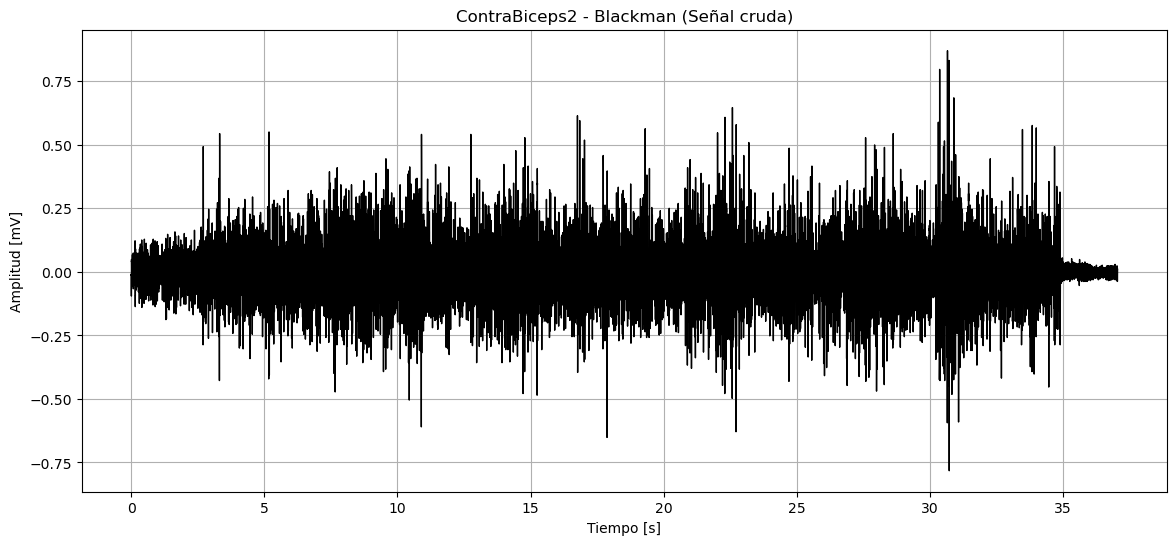

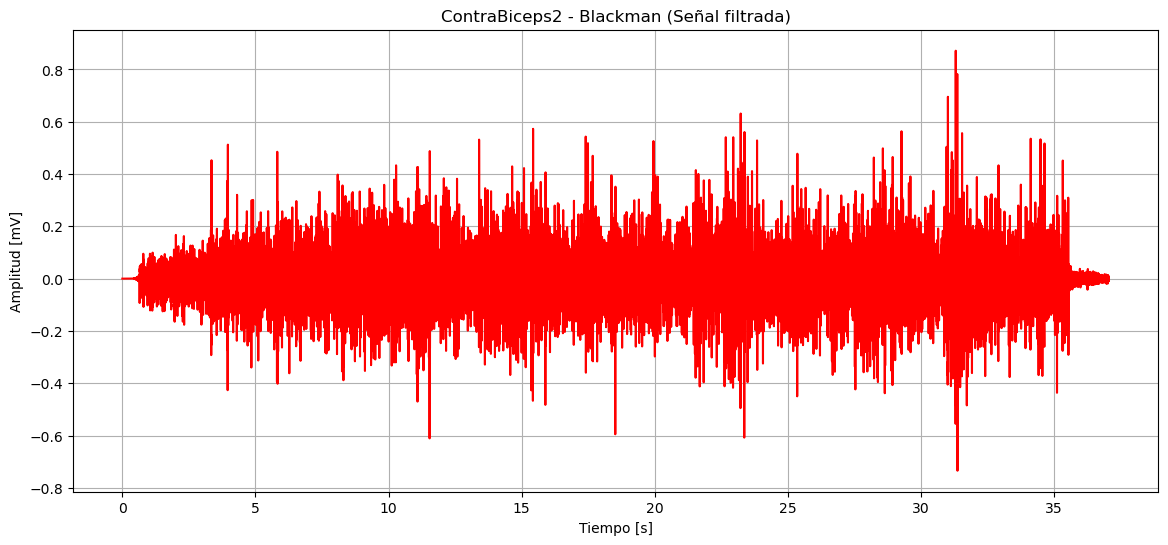

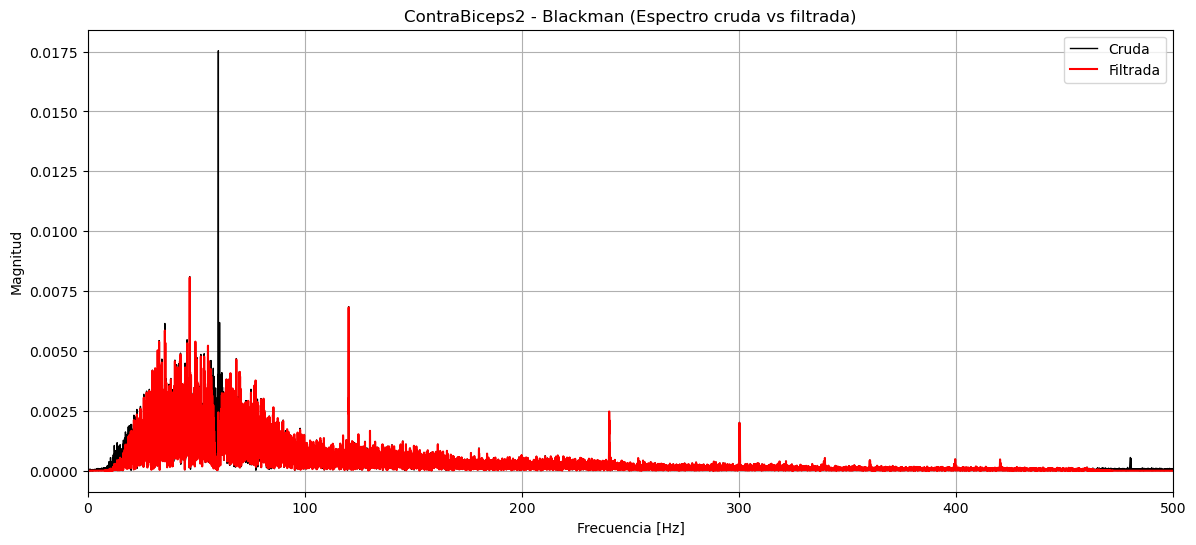

In [38]:
# === 7. Procesamiento de señales y cálculo de SNR ===
for nombre_senal, ruta_senal in archivos.items():
    EMG = cargar_emg(ruta_senal)
    t = np.arange(len(EMG)) / fs

    for nombre_filtro, info in rutas_filtros.items():
        # Cargar coeficientes
        b_bp, a_bp = cargar_coef(info["bp"], fir=info["fir"])
        b_notch, a_notch = cargar_coef(info["notch"], fir=info["fir"])

        # Aplicar pasabanda
        EMG_bp = lfilter(b_bp, a_bp, EMG)

        # Aplicar notch
        EMG_filtrada = lfilter(b_notch, a_notch, EMG_bp)

        # Calcular SNR en banda 20-450 Hz
        snr_val = calcular_snr_fft(EMG_filtrada, fs)
        print(f"SNR de {nombre_senal} con {nombre_filtro}: {snr_val:.2f} dB")

        # Graficar señal cruda
        plt.figure(figsize=(14,6))
        plt.plot(t, EMG, color="black", linewidth=1)
        plt.xlabel("Tiempo [s]")
        plt.ylabel("Amplitud [mV]")
        plt.title(f"{nombre_senal} - {nombre_filtro} (Señal cruda)")
        plt.grid(True)
        plt.show()

        # Graficar señal filtrada
        plt.figure(figsize=(14,6))
        plt.plot(t, EMG_filtrada, color="red", linewidth=1.5)
        plt.xlabel("Tiempo [s]")
        plt.ylabel("Amplitud [mV]")
        plt.title(f"{nombre_senal} - {nombre_filtro} (Señal filtrada)")
        plt.grid(True)
        plt.show()

        # Espectro de la señal
        plt.figure(figsize=(14,6))
        plt.magnitude_spectrum(EMG, Fs=fs, scale='linear', color="black", linewidth=1, label="Cruda")
        plt.magnitude_spectrum(EMG_filtrada, Fs=fs, scale='linear', color="red", linewidth=1.5, label="Filtrada")
        plt.title(f"{nombre_senal} - {nombre_filtro} (Espectro cruda vs filtrada)")
        plt.xlabel("Frecuencia [Hz]")
        plt.ylabel("Magnitud")
        plt.xlim(0, 500)
        plt.legend()
        plt.grid(True)
        plt.show()